In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, log_loss
)
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('../SnP_daily_update_AMZN_features_with_target.csv')

# Load feature list from AMZN_methods_all_in_one.csv
feature_df = pd.read_csv('../AMZN_methods_all_in_one.csv')
features = feature_df['feature'].tolist()
print("Features used:", features)
print("Target: y_ret_t1")

Features used: ['lower_wick', 'vol_chg', 'ma_gap_20', 'vol_ratio_20', 'ret_1', 'upper_wick', 'co_ret', 'range_pct', 'ret_2', 'vol_10', 'ret_5', 'vol_20', 'ret_4', 'ma_gap_10', 'ret_3']
Target: y_ret_t1


In [3]:
# Prepare X and y
X = data[features].copy()
y = data['y_ret_t1'].copy()

# Drop rows with NaN
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

print(f"Dataset shape: X={X.shape}, y={y.shape}")

# Train-test split (time-series: no shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(f"Train: {X_train.shape[0]} samples | Test: {X_test.shape[0]} samples")

Dataset shape: X=(4028, 15), y=(4028,)
Train: 3222 samples | Test: 806 samples


In [9]:
# Scale features and apply Polynomial Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial Features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print(f"Polynomial features shape: {X_train_poly.shape[1]} features (from {X_train_scaled.shape[1]} original)")

# Train Polynomial Regression
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predictions
y_pred_train = model.predict(X_train_poly)
y_pred_test = model.predict(X_test_poly)

print("\nModel trained successfully!")

Polynomial features shape: 135 features (from 15 original)

Model trained successfully!


In [14]:
# ==================== REGRESSION METRICS ====================
print("=" * 55)
print("          REGRESSION METRICS")
print("=" * 55)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"{'Metric':<20} {'Train':>12} {'Test':>12}")
print("-" * 45)
print(f"{'MSE (Loss)':<20} {mse_train:>12.6f} {mse_test:>12.6f}")
print(f"{'RMSE':<20} {rmse_train:>12.6f} {rmse_test:>12.6f}")
print(f"{'MAE':<20} {mae_train:>12.6f} {mae_test:>12.6f}")
print(f"{'R² Score':<20} {r2_train:>12.6f} {r2_test:>12.6f}")

          REGRESSION METRICS
Metric                      Train         Test
---------------------------------------------
MSE (Loss)               0.000391     0.000459
RMSE                     0.019765     0.021414
MAE                      0.014027     0.015317
R² Score                 0.096756    -0.121247


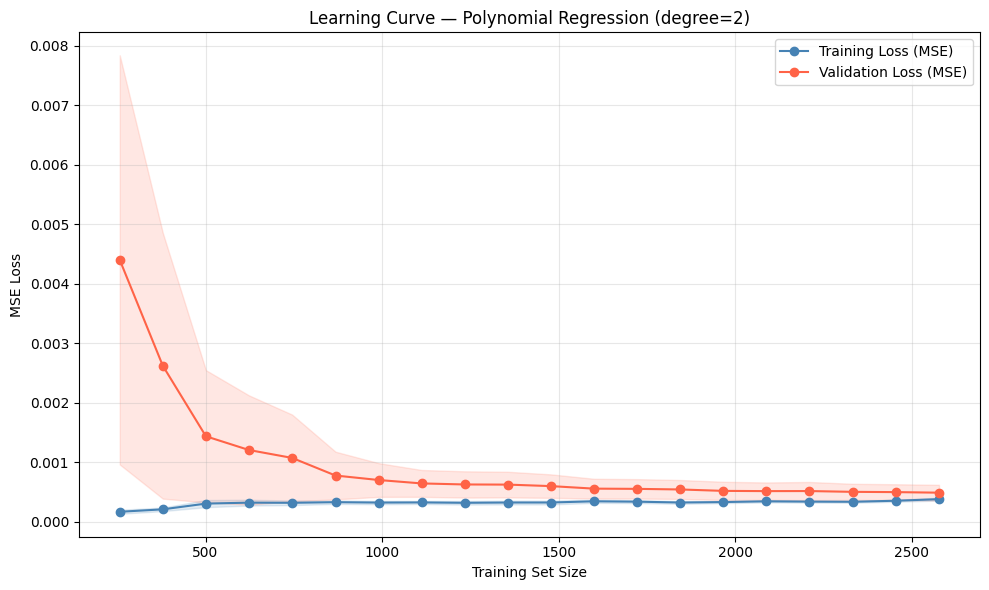

In [15]:
# ==================== Learning Curve (Loss Graph) ====================
from sklearn.model_selection import learning_curve

train_sizes, train_scores_mse, test_scores_mse = learning_curve(
    LinearRegression(),
    X_train_poly, y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
    cv=5,
    scoring='neg_mean_squared_error',
    shuffle=False,
    n_jobs=-1
)

# Convert negative MSE to positive
train_loss = -train_scores_mse.mean(axis=1)
test_loss = -test_scores_mse.mean(axis=1)
train_loss_std = train_scores_mse.std(axis=1)
test_loss_std = test_scores_mse.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_loss, 'o-', color='steelblue', label='Training Loss (MSE)')
plt.fill_between(train_sizes, train_loss - train_loss_std, train_loss + train_loss_std, alpha=0.15, color='steelblue')
plt.plot(train_sizes, test_loss, 'o-', color='tomato', label='Validation Loss (MSE)')
plt.fill_between(train_sizes, test_loss - test_loss_std, test_loss + test_loss_std, alpha=0.15, color='tomato')
plt.xlabel('Training Set Size')
plt.ylabel('MSE Loss')
plt.title('Learning Curve — Polynomial Regression (degree=2)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

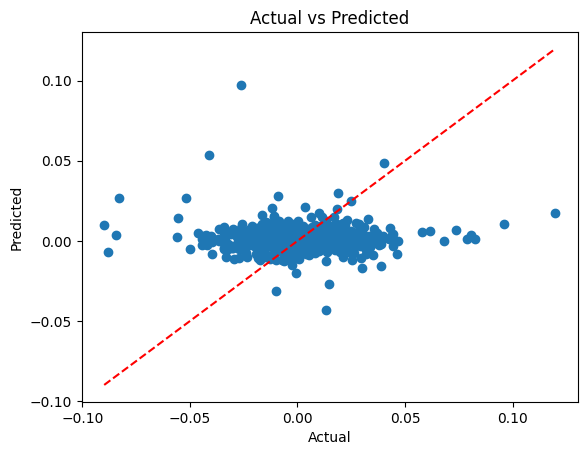

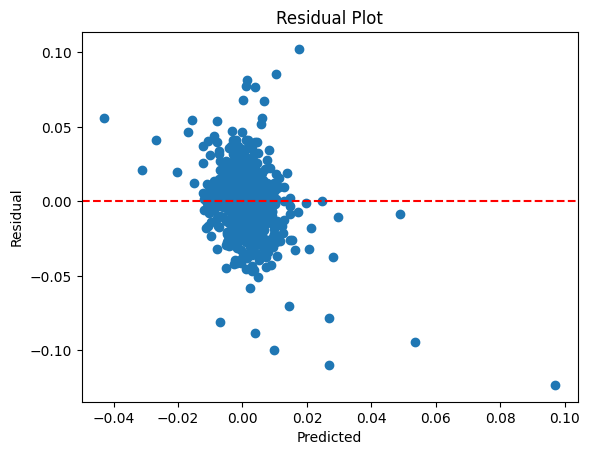

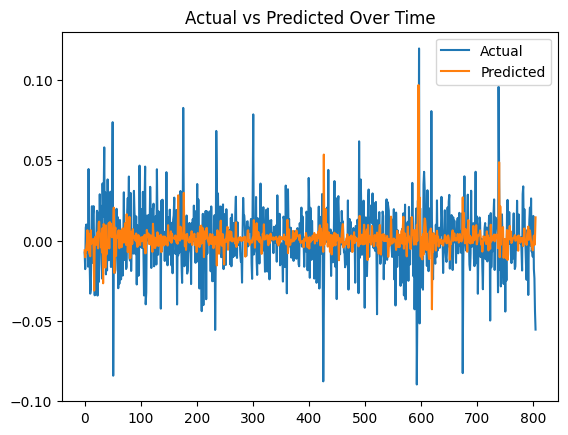

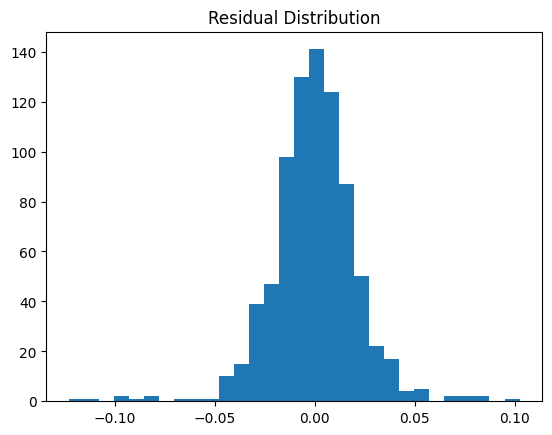

In [12]:
# ==================== PLOTS ====================

plt.scatter(y_test, y_pred_test)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

residuals = y_test - y_pred_test

plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.show()

plt.plot(y_test.values, label="Actual")
plt.plot(y_pred_test, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Over Time")
plt.show()

plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.show()
